In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

#mcc implementation
from torchmetrics.classification import MultilabelMatthewsCorrCoef

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_transforms = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=train_transforms)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Dropout(p=0.5),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.Dropout(p=0.5),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Dropout(p=0.5),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.Dropout(p=0.5),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 291):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Dropout(p=0.5),
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
                nn.Dropout(p=0.5),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:
net = ResNet(ResidualBlock, [4, 3, 2, 1]).to(device)
net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Dropout(p=0.5, inplace=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
      )
      (conv2): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Dropout(p=0.5, inplace=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [6]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

mcc_list = []

lrs = []
steps = []

epoch_affichage = 1

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 76)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    """
    print("predicted = ",predicted)
    print("labels = ",labels)
    """
    
    #MCC implementation
    """
    metric_mcc = MultilabelMatthewsCorrCoef(num_labels=291)
    metric_mcc(predicted, labels)
    mcc_list.append(metric_mcc)
    """
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 75: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % epoch_affichage == 0: #ici changer pour la frequence d'affichage
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/76 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 1.863% | Train Loss => 5.41836
validation Acc.  => 2.226% | validation Loss  => 5.32872
Accuracy of the network on test images: 2 %

Epoch: 1
Train Acc. => 2.397% | Train Loss => 5.16838
validation Acc.  => 2.774% | validation Loss  => 4.99370
Accuracy of the network on test images: 3 %

Epoch: 2
Train Acc. => 3.390% | Train Loss => 4.88153
validation Acc.  => 3.984% | validation Loss  => 4.76310
Accuracy of the network on test images: 4 %

Epoch: 3
Train Acc. => 4.082% | Train Loss => 4.68973
validation Acc.  => 4.758% | validation Loss  => 4.59718
Accuracy of the network on test images: 4 %

Epoch: 4
Train Acc. => 5.113% | Train Loss => 4.53829
validation Acc.  => 5.597% | validation Loss  => 4.47718
Accuracy of the network on test images: 5 %

Epoch: 5
Train Acc. => 6.041% | Train Loss => 4.42498
validation Acc.  => 6.629% | validation Loss  => 4.36213
Accuracy of the network on test images: 6 %

Epoch: 6
Train Acc. => 7.314% | Train Loss => 4.30884
validatio

Accuracy of the network on test images: 47 %

Epoch: 52
Train Acc. => 49.157% | Train Loss => 1.80783
validation Acc.  => 47.435% | validation Loss  => 1.85791
Accuracy of the network on test images: 48 %

Epoch: 53
Train Acc. => 49.513% | Train Loss => 1.78447
validation Acc.  => 48.952% | validation Loss  => 1.83305
Accuracy of the network on test images: 47 %

Epoch: 54
Train Acc. => 49.630% | Train Loss => 1.77235
validation Acc.  => 48.048% | validation Loss  => 1.85094
Accuracy of the network on test images: 48 %

Epoch: 55
Train Acc. => 50.487% | Train Loss => 1.75259
validation Acc.  => 48.968% | validation Loss  => 1.81333
Accuracy of the network on test images: 50 %

Epoch: 56
Train Acc. => 50.348% | Train Loss => 1.74561
validation Acc.  => 49.081% | validation Loss  => 1.80045
Accuracy of the network on test images: 48 %

Epoch: 57
Train Acc. => 50.726% | Train Loss => 1.72113
validation Acc.  => 49.532% | validation Loss  => 1.78832
Accuracy of the network on test images: 

## Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

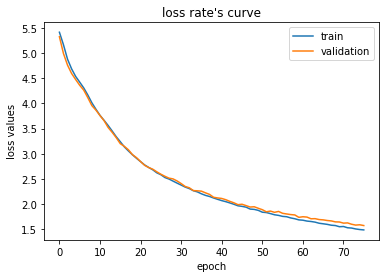

In [9]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

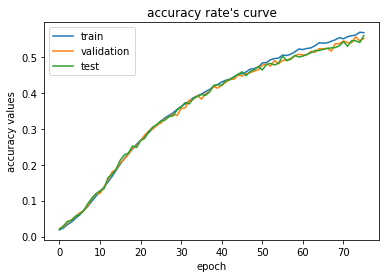

In [10]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [11]:
#plt.plot(mcc_list, label='MCC')
#plt.xlabel("epoch")
#plt.ylabel("MCC values")
#plt.title("MCC curve")
#plt.legend()
#plt.show()

In [12]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[ 8  6  0 ...  0  0  0]
 [ 1 38  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0 29]]


<AxesSubplot:>

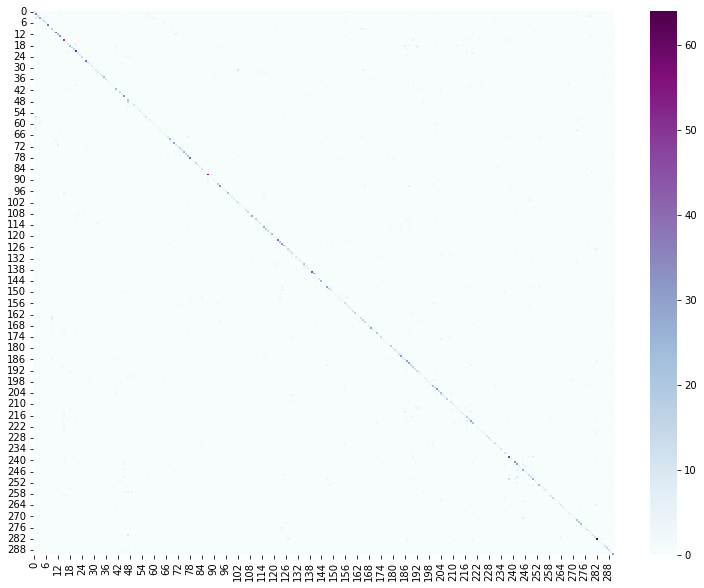

In [13]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [14]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 40.          64.40677966  58.33333333  49.12280702  50.
  73.68421053  40.90909091  89.36170213  60.          44.73684211
  40.          80.39215686  48.93617021  58.92857143  11.11111111
  55.81395349  27.27272727  42.30769231  41.50943396  43.18181818
  57.69230769  77.94117647  35.48387097  80.          54.16666667
  14.28571429  87.23404255  85.71428571  28.57142857 100.
  83.33333333  29.41176471  41.66666667  54.54545455 100.
  66.66666667  66.66666667  33.33333333  37.5         11.11111111
   9.09090909  63.88888889  22.22222222  87.5         57.14285714
  82.5         50.          78.57142857   8.69565217  50.
 100.          25.          62.5         81.81818182  80.
  54.54545455  33.33333333  20.          63.63636364  20.
  23.52941176  20.          36.36363636  22.72727273  28.57142857
  33.33333333  50.          29.41176471  72.72727273  16.66666667
  82.85714286  50.          65.          66.66666667  57.14285714
  85.71428571  50.          57.5         68.75        27.2

## Save

In [15]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [16]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [17]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [18]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"